In [1]:
# %pip install torch torchvision albumentations

### Importing libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

### UNET implementation

In [4]:
class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        # 161 x 161, output: 160 x 160
        
        # Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        # Up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            # Meaning ba ng dim=1 dito ay one line lang or vector lang ang concatenated tensor?
            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            x = self.ups[idx+1](concat_skip)
        
        x = self.final_conv(x)
        return x
    
def test():
    # batch size, # of channels, 
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape
    
test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [25]:
class KvasirDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 0).astype(np.uint8)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image.float(), mask.long()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


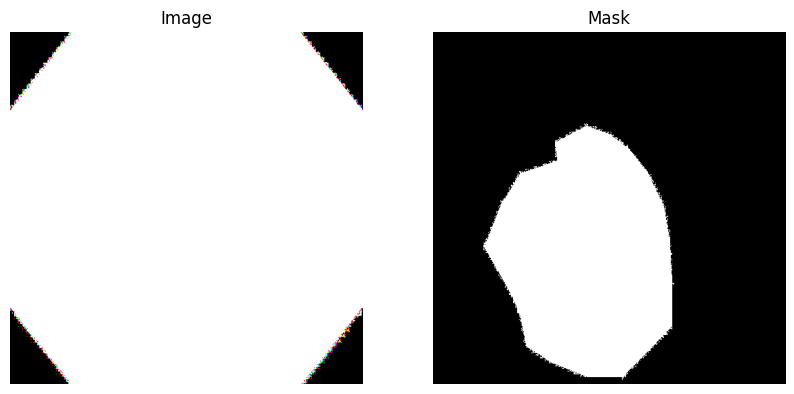

In [26]:
image_dir = "sessile-main-Kvasir-SEG\images"
mask_dir = "sessile-main-Kvasir-SEG\masks"

transform = A.Compose([
    A.Resize(512, 512),
    # A.Normalize(),
    ToTensorV2(),
])

# Example: Plot one image and its corresponding mask
dataset = KvasirDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
image, mask = dataset[0]  # Get the first image and mask

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
# expects shape (H, W, C) but image has shape (C, H, W)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()

In [27]:
learning_rate = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
num_epochs = 1
model = UNET(in_channels=3, out_channels=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dataset = KvasirDataset(image_dir, mask_dir, transform=transform)

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

KeyboardInterrupt: 